<br>

<center>
    <span style="font-size:24px; font-weight:bold;">Twitter Sentiment Analysis - RNN / NLP / BERT LLM</span>
</center>

<br>

<hr style="border: none; border-top: 1px solid #000;">

<center>
    <span>
        Created by <b>Ian Yap</b>
        &emsp;|&emsp;
        Data from <a href="https://www.kaggle.com/datasets/kazanova/sentiment140"><b>Kaggle</b></a>
        &nbsp;
    </span>
</center>

<br>

<center>
    <span>
        <a href="https://www.linkedin.com/in/ian-yap-052870139/"><b>LinkedIn</b></a>
        &emsp;|&emsp;
        <a href="https://xiyap.github.io/"><b>Portfolio</b></a>
    </span>
</center>
    
<hr style="border: none; border-top: 1px solid #000;">


<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Background</span>

Sentiment analysis provides valuable insights into public opinion, brand perception, market trends, and more. These analysis enables organizations to gain insights from social media data, which helps them make informed business decisions based on data. This analysis is commonly used in social media monitoring, customer feedback analysis, and market research.

In this project, we will fine-tune a LLM model to predict the sentiment of user posts on Twitter (currently 'X').

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Objective</span>

The *main* objective of this project is to **develop a predictive model which can intepret a user tweet and determine the sentiment of the tweet whether positive or negative.**

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Feature Information</span>

- **sentiment**: Polarity of tweet
- **id**: ID of tweet
- **date**: Date of tweet
- **query**: The query
- **username**: User who tweet
- **tweet**: Text of tweet

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Import Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import re

from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer, AdamW

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm

import time

import joblib

In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)

In [3]:
torch.cuda.is_available()

True

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Data Loading</span>

Loading the dataset to be used for analysis and model development.

In [4]:
file_path = 'training.1600000.processed.noemoticon.csv'

In [5]:
df_original = pd.read_csv(file_path, encoding = 'latin1', header = None)
df = df_original.copy()

In [6]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.columns = ['sentiment', 'id', 'date', 'query', 'username', 'tweet']
df.columns

Index(['sentiment', 'id', 'date', 'query', 'username', 'tweet'], dtype='object')

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Feature Engineering</span>

Check for any duplicated data and remove them as it will affect the data analysis and training of the predictive model:

In [8]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')
# df.drop_duplicates(inplace = True)
# print(f'Number of duplicated rows: {df.duplicated().sum()}')

Number of duplicated rows: 0


Next, we will check the shape of the dataset and its status.

Looks like our dataset has 1,600,000 rows, 6 columns, no missing data and the data types of each attributes are correct.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   username   1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
missing_value = df.isna().sum()
missing_value_percentage = (missing_value / len(df)) * 100

pd.DataFrame({'Total Missing Value': missing_value, 'Missing Percentage': missing_value_percentage})

,Total Missing Value,Missing Percentage
sentiment,0,0.0
id,0,0.0
date,0,0.0
query,0,0.0
username,0,0.0
tweet,0,0.0


We explore the dataset using descriptive statistics to gain insights on the data.

In [11]:
num_col = df.select_dtypes(include = 'number').describe()
num_col.transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,1600000.0,2.000000e+00,2.000001e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00
id,1600000.0,1.998818e+09,1.935761e+08,1.467810e+09,1.956916e+09,2.002102e+09,2.177059e+09,2.329206e+09


In [12]:
cat_col = df.select_dtypes(include = 'object').describe()
cat_col.transpose()

,count,unique,top,freq
date,1600000,774363,Mon Jun 15 12:53:14 PDT 2009,20
query,1600000,1,NO_QUERY,1600000
username,1600000,659775,lost_dog,549
tweet,1600000,1581466,isPlayer Has Died! Sorry,210


Remove insignificant features:

In [13]:
df.drop(['id', 'date', 'query', 'username'], axis = 1, inplace = True)
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [14]:
num_col = df.select_dtypes(include = 'number').describe()
num_col.transpose()

for num in num_col:
    print(f'Unique values in column {num}: \
    \n{df[num].unique()} \
    \n')

Unique values in column sentiment:     
[0 4]     



<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Exploratory Data Analysis (EDA) & Visualization</span>

Explore and gain insights to the data through visualization:

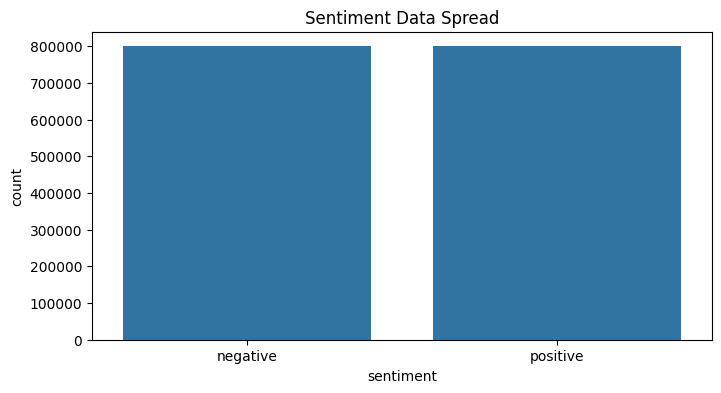

In [15]:
plt.figure(figsize = (8, 4))

sns.countplot(data = df, x = df['sentiment'])
plt.title('Sentiment Data Spread')
plt.xticks(ticks = [0, 1], labels = ['negative', 'positive'])
plt.show()

The spread between negative and positive sentiment tweets are even.

In [16]:
print('Tweet example:')
df.iloc[799995:800005]

Tweet example:


,sentiment,tweet
799995,0,Sick Spending my day laying in bed listening ...
799996,0,Gmail is down?
799997,0,rest in peace Farrah! So sad
799998,0,@Eric_Urbane Sounds like a rival is flagging y...
799999,0,has to resit exams over summer... wishes he w...
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


Tweets posted by users are quite messy due to the nature of twitter where user replies or retweets on a tweet will first post the text @\<name_of_other_user>. Links posted such as https://xiyap.github.io/ also makes the tweet messy which will confuse the sentiment model. Therefore, we will process the tweets before feeding it into the model.

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Data Preparation</span>

In this section, we will prepare the data and define some functions to be used for model development.

Converting the labels to 0 and 1:

Labels:
- 0: 0 (negative sentiment)
- 1: 4 (positive sentiment)

In [17]:
df.loc[df['sentiment'] == 4, 'sentiment'] = 1
df['sentiment'].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

<span style="font-size:18px; font-weight:bold;">Remove Hyperlinks and Mentions:</span>

| = or

@\S+ = @(word)

https?:\S+ = http:(word) or https:(word)

[^A-Za-z0-9]+ = enable A-Z, a-z, 0-9

In [18]:
def preprocess(text):
    text_cleaning_re = "@\S+|https?:\S+|[^A-Za-z0-9]+"
    text_clean = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text_clean

In [19]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

Due to current computational resource limitations, only 200,000 rows of data will be used:

In [20]:
df_mini = df.iloc[700000:900000, :]
df_mini

,sentiment,tweet
700000,0,people are tweeting advice on how to combat te...
700001,0,can t go 2 the anberlin show 2nite tickets sol...
700002,0,woke up with lots of wisdom teeth drama gotta ...
700003,0,not yet dude gonna have to buy a new one
700004,0,everytime i fall asleep my dreams are haunted
...,...,...
899995,1,haha no the remark on maternity leave fired me...
899996,1,and to you
899997,1,okie doke time for me to escape for the north ...
899998,1,finished the lessons hooray


In [21]:
df_mini.sentiment.value_counts()

sentiment
0    100000
1    100000
Name: count, dtype: int64

<span style="font-size:18px; font-weight:bold;">Train/Val/Test Split:</span>

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df_mini.tweet, df_mini.sentiment,
    random_state = seed,
    test_size = 0.3,
    stratify = df_mini.sentiment
    )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    random_state = seed,
    test_size = 0.5,
    stratify = y_temp
    )

<span style="font-size:18px; font-weight:bold;">Truncate Length:</span>

To improve training speeds, we will choose the padding length where majority of tweets resides.

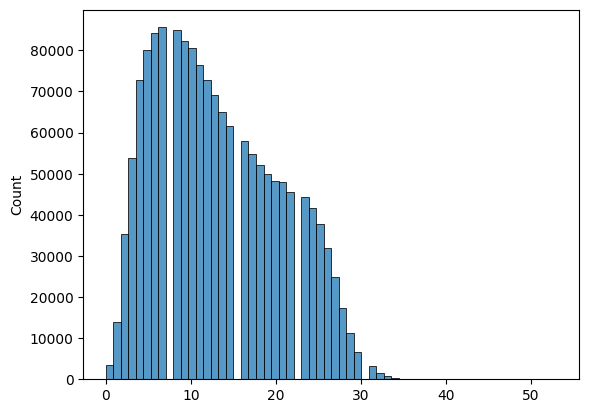

In [23]:
tweet_len = [len(i.split()) for i in df.tweet]

sns.histplot(tweet_len, bins = 60);

Most of the tweets have word counts of below 25. There is a significant dropoff of tweets above 25 words. Hence, we will use 25 as the padding length which makes all the tweets the same length while does with longer tweets will be truncated.

<span style="font-size:18px; font-weight:bold;">Tokenize Tweets:</span>

We will utilize the tokenizer from a pre-trained LLM model 'distilbert-base-uncased' which has been trained on a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers). By utilizing transfer learning, we will save lots of time and effort in training our own NLP model.

In [24]:
model_name = 'distilbert/distilbert-base-uncased'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [25]:
# Tokenize the tweets in batches
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True
)

<span style="font-size:18px; font-weight:bold;">Prepare Datasets:</span>

In [26]:
# Convert to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_label = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_label = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_label = torch.tensor(y_test.tolist())

In [27]:
# Small batch size used due to computational resource limitations
batch_size = 4

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_label)
val_data = TensorDataset(val_seq, val_mask, val_label)
test_data = TensorDataset(test_seq, test_mask, test_label)

# Initiate DataLoader
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

<span style="font-size:18px; font-weight:bold;">Import Functions:</span>

In [28]:
# Custom function to print classification report and confusion matrix
def model_report(y_test, prediction):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

    print(classification_report(y_test, prediction, target_names = ['Negative Sentiment (Class 0)','Positive Sentiment (Class 1)']))
    cm = confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Fine Tuning BERT Model with Custom Classification Head</span>

DistilBertModel body architecture imported:

In [29]:
print(model)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

As the BERT model was trained on regular english language which is similar to twitter tweets which are random topics instead of domain specific information, we will use the body architecture of the BERT model without changing its layers.

To fine tune the model to generalize better to our Twitter dataset, a classification head will be added and trained on the get the optimal weights for this application.

Ideally, the last N layers of the BERT model would be unfreezed to fine-tune the weights to our data. However due to computational resource limitations, we will freeze the whole body.

In [30]:
# Layers to freeze
# N = 2

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last N layers of pre-trained model
# for param in model.transformer.layer[-N:].parameters():
#     param.requires_grad = True

Define the model architecture:

In [31]:
class TweetClassifer(nn.Module):
    def __init__(self, model, num_classes = 2):
        super(TweetClassifer, self).__init__()

        # Where we define all the parts of the model
        self.base_model = model
        self.classifier = nn.Sequential(
            nn.Linear(model.config.hidden_size, num_classes),
            nn.Sigmoid()
            )

    def forward(self, forward_seq, forward_mask):
        # Connect these parts and return the output
        cls_hs = self.base_model(forward_seq, attention_mask = forward_mask)
        cls_output = cls_hs.last_hidden_state[:, 0, :]
        output = self.classifier(cls_output)
        return output

Create an instance of our new model:

In [32]:
model_finetune = TweetClassifer(model, num_classes = 2)

In [33]:
print(model_finetune)

TweetClassifer(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

<span style="font-size:18px; font-weight:bold;">Model Training Loop:</span>

Training the model for N epochs:

In [53]:
num_epochs = 10
pause_duration_seconds = 60
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_val_loss = float('inf')
val_preds = []
true_labels = []

model_finetune = TweetClassifer(model, num_classes = 2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_finetune = model_finetune.to(device)
optimizer = AdamW(model_finetune.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1, verbose = True)

for epoch in range(num_epochs):
    # Training
    model_finetune.train()
    total_loss = 0
    total_accuracy = 0
    total_pred = 0
    
    for batch in tqdm(train_loader, desc = 'Training Loop'):
        batch_seq, batch_mask, batch_labels = batch
        batch_seq, batch_mask, batch_labels = batch_seq.to(device), batch_mask.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        pred = model_finetune(batch_seq, batch_mask)
        loss = criterion(pred, batch_labels)
        total_loss = total_loss + loss.item()

        _, predicted_labels = torch.max(pred, 1)
        total_accuracy += (predicted_labels == batch_labels).sum().item()
        total_pred += batch_labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_finetune.parameters(), 1.0)
        optimizer.step()

        pred = pred.detach().cpu().numpy()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_accuracy / total_pred

    # Validation
    model_finetune.eval()
    total_loss = 0
    total_accuracy = 0
    total_pred = 0

    for batch in tqdm(val_loader, desc = 'Validation Loop'):
        batch_seq, batch_mask, batch_labels = batch
        batch_seq, batch_mask, batch_labels = batch_seq.to(device), batch_mask.to(device), batch_labels.to(device)

        with torch.no_grad():
            pred = model_finetune(batch_seq, batch_mask)
            loss = criterion(pred, batch_labels)
            total_loss = total_loss + loss.item()

            _, predicted_labels = torch.max(pred, 1)
            total_accuracy += (predicted_labels == batch_labels).sum().item()
            total_pred += batch_labels.size(0)
            val_preds.extend(predicted_labels.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

            pred = pred.detach().cpu().numpy()

    avg_val_loss = total_loss / len(val_loader)
    avg_val_accuracy = total_accuracy / total_pred

    # Update best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_finetune.state_dict(), 'best_weights.pt')

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracy.append(avg_train_accuracy)
    val_accuracy.append(avg_val_accuracy)

    print(f'\n Epoch {epoch + 1}/{num_epochs} \n Training loss: {avg_train_loss}, Validation loss: {avg_val_loss} \n Training accuracy: {avg_train_accuracy}, Validation accuracy: {avg_val_accuracy}')
    
    # Pause for N seconds for GPU cooling
    print(f'\n Pausing for {pause_duration_seconds} seconds...')
    time.sleep(pause_duration_seconds)

Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 1/10 
 Training loss: 0.6597077185451985, Validation loss: 0.6316766558885575 
 Training accuracy: 0.6739428571428572, Validation accuracy: 0.7104333333333334

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 2/10 
 Training loss: 0.6214040224339281, Validation loss: 0.6059479439457257 
 Training accuracy: 0.7113642857142857, Validation accuracy: 0.7214333333333334

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 3/10 
 Training loss: 0.6034907101188387, Validation loss: 0.5921266994516055 
 Training accuracy: 0.7204214285714285, Validation accuracy: 0.7294666666666667

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 4/10 
 Training loss: 0.5928194254279137, Validation loss: 0.5832574539502462 
 Training accuracy: 0.7263785714285714, Validation accuracy: 0.7342666666666666

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 5/10 
 Training loss: 0.5859033007425921, Validation loss: 0.5768892306288084 
 Training accuracy: 0.7291, Validation accuracy: 0.7392

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 6/10 
 Training loss: 0.5806494236145701, Validation loss: 0.572147972214222 
 Training accuracy: 0.73305, Validation accuracy: 0.7416333333333334

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 7/10 
 Training loss: 0.5762093530399459, Validation loss: 0.5683631531437238 
 Training accuracy: 0.7363642857142857, Validation accuracy: 0.7436666666666667

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 8/10 
 Training loss: 0.5730296578739371, Validation loss: 0.5653304056962332 
 Training accuracy: 0.7374428571428572, Validation accuracy: 0.7450666666666667

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 9/10 
 Training loss: 0.5702938777591501, Validation loss: 0.563127543191115 
 Training accuracy: 0.7397071428571429, Validation accuracy: 0.7463

 Pausing for 60 seconds...


Training Loop:   0%|          | 0/35000 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/7500 [00:00<?, ?it/s]


 Epoch 10/10 
 Training loss: 0.5681086876571179, Validation loss: 0.5606613012313842 
 Training accuracy: 0.7408642857142858, Validation accuracy: 0.7486333333333334

 Pausing for 60 seconds...


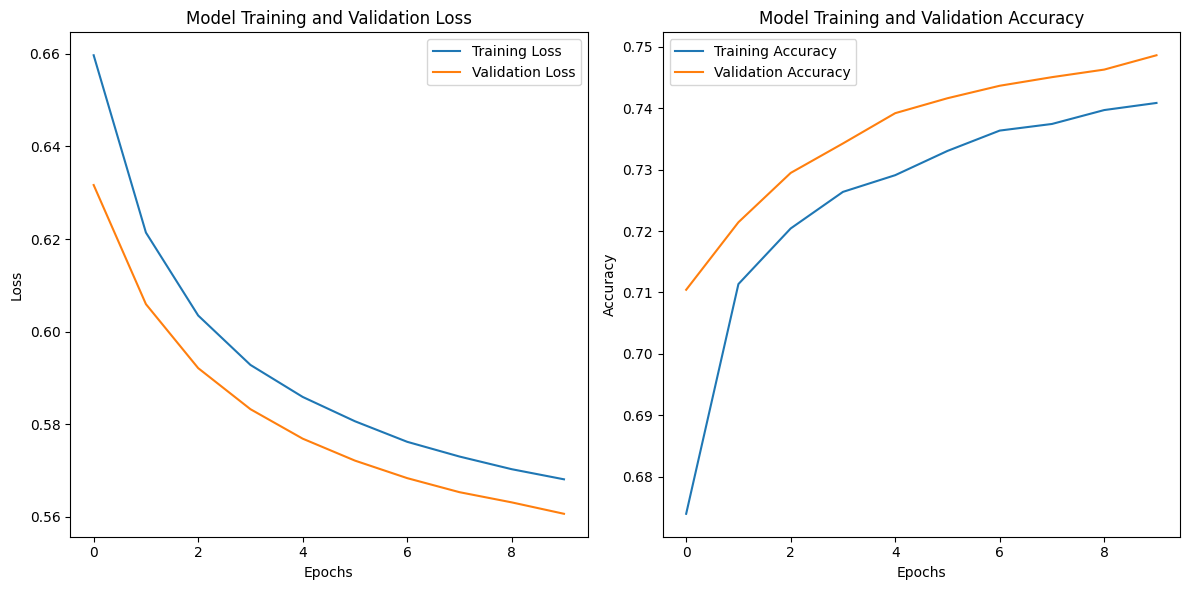

In [54]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

metrics = ['losses', 'accuracy']
titles = ['Loss', 'Accuracy']
labels = ['Training', 'Validation']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    # ax = axes[i // 2, i % 2]
    ax = axes[i]
    train_metric = eval(f'train_{metric}')
    val_metric = eval(f'val_{metric}')
    ax.plot(train_metric, label = f'{labels[0]} {title}')
    ax.plot(val_metric, label = f'{labels[1]} {title}')
    ax.set_title(f'Model Training and Validation {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    # ax.set_xlim(0, 10)
    # ax.set_xticks(np.arange(0, 10, step = 1))
    ax.legend()

# fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

In [55]:
min_val_losses = min(val_losses)
max_val_accuracy = max(val_accuracy)
print(f'Min loss on validation set: {min_val_losses:.3f}')
print(f'Max binary accuracy on validation set: {max_val_accuracy * 100:.3f} %')

Min loss on validation set: 0.561
Max binary accuracy on validation set: 74.863 %


                              precision    recall  f1-score   support

Negative Sentiment (Class 0)       0.73      0.74      0.74    150000
Positive Sentiment (Class 1)       0.74      0.73      0.73    150000

                    accuracy                           0.74    300000
                   macro avg       0.74      0.74      0.74    300000
                weighted avg       0.74      0.74      0.74    300000



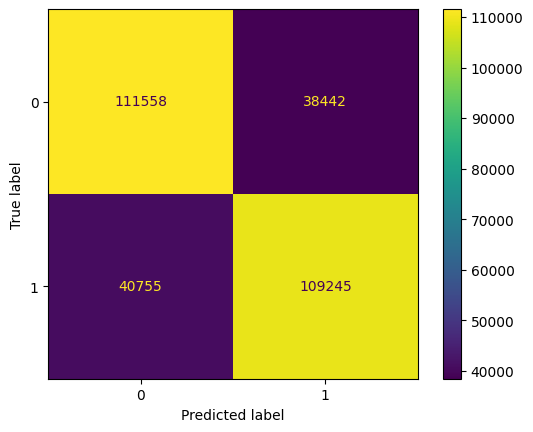

In [78]:
model_report(true_labels, val_preds)

<span style="font-size:18px; font-weight:bold;">Test Set:</span>

<span style="font-size:14px; font-weight:bold;">Save Model:</span>

In [81]:
# Save as .pth
torch.save(model_finetune, 'TweetClassifer_2class_model.pth')

In [82]:
# Save as .pkl
path = 'best_weights.pt'
model_finetune.load_state_dict(torch.load(path))
joblib.dump(model_finetune, 'TweetClassifer_2class_model.pkl')

['TweetClassifer_2class_model.pkl']

<span style="font-size:14px; font-weight:bold;">Load Model:</span>

In [83]:
# Load as .pth
path = 'best_weights.pt'
tweet_classifier_model = torch.load('TweetClassifer_2class_model.pth')
tweet_classifier_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [84]:
# Load as .pkl
tweet_classifier_model = joblib.load('TweetClassifer_2class_model.pkl')

<span style="font-size:14px; font-weight:bold;">Model Performance on Test Set:</span>

In [85]:
# Clear GPU memory
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tweet_classifier_model = tweet_classifier_model.to(device)

In [86]:
tweet_classifier_model.eval()

TweetClassifer(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [ ]:
# Predict on test data > CUDA OOM
# with torch.no_grad():
#     test_preds = tweet_classifier_model(test_seq.to(device), test_mask.to(device))
#     test_preds = test_preds.detach().cpu().numpy()

In [89]:
test_preds = []

for batch in  tqdm(test_loader, desc = 'Testing Loop'):
    batch_seq, batch_mask, batch_labels = batch
    
    # Predict on test data
    with torch.no_grad():
        test_preds = tweet_classifier_model(batch_seq.to(device), batch_mask.to(device))
        _, predicted_labels = torch.max(test_preds, 1)
        test_preds.extend(predicted_labels.cpu().numpy())

test_preds = np.array(test_preds)

                              precision    recall  f1-score   support

Negative Sentiment (Class 0)       0.75      0.75      0.75     15000
Positive Sentiment (Class 1)       0.75      0.74      0.75     15000

                    accuracy                           0.75     30000
                   macro avg       0.75      0.75      0.75     30000
                weighted avg       0.75      0.75      0.75     30000



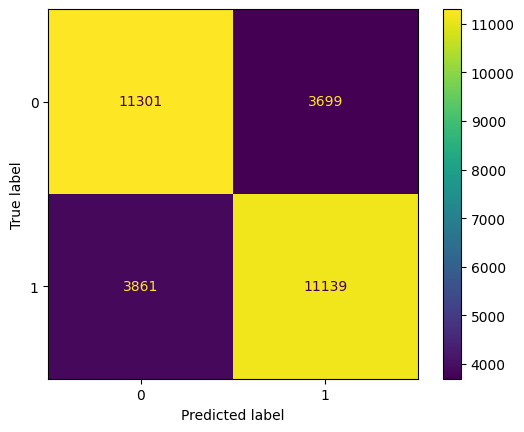

In [94]:
model_report(test_label, test_preds)

#########

\<span style="font-size:24px; font-weight:bold; text-decoration:underline;">Model\</span>

\<span style="font-size:18px; font-weight:bold;">Nano:\</span>

#########

<span style="font-size:18px; font-weight:bold;">Inference + Streamlit Function:</span>

In [95]:
import torch
import joblib
from transformers import AutoTokenizer
from torch.nn.functional import softmax

# Preprocess input sentence
def preprocess_input(sentence):
    text_cleaning_re = "@\S+|https?:\S+|[^A-Za-z0-9]+"
    text_clean = re.sub(text_cleaning_re, ' ', str(sentence).lower()).strip()
    return text_clean

def tweet_inference(pkl_model_path, input_sentence):
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

    # Preprocess and tokenize input sentence
    processed_sentence = preprocess_input(input_sentence)
    tokenized_input = tokenizer.encode_plus(
        processed_sentence,
        max_length = 25,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'pt'
    )

    # Push tensors to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_ids = tokenized_input['input_ids'].to(device)
    attention_mask = tokenized_input['attention_mask'].to(device)

    # Load fine-tuned model
    tweet_classifier_model = joblib.load(pkl_model_path)
    tweet_classifier_model = tweet_classifier_model.to(device)

    # Set model to evaluation mode
    tweet_classifier_model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = tweet_classifier_model(input_ids, attention_mask)
        probabilities = softmax(outputs, dim = 1)
        _, predicted_label = torch.max(outputs, 1)
        predicted_class = predicted_label.item()
        probability_of_predicted_class = probabilities[0][predicted_class].item()

    # Return results
    sentiment_labels = ['Negative', 'Positive']
    predicted_sentiment = sentiment_labels[predicted_class]
    
    return predicted_sentiment, probability_of_predicted_class

In [101]:
new_tweet = 'Had a wonderful time at the concert!'
pkl_saved_model = 'TweetClassifer_2class_model.pkl'
results = tweet_inference(pkl_saved_model, new_tweet)

In [102]:
print(f'Predicted Sentiment: {results[0]}')
print(f'Percentage of Predicted Sentiment: {results[1] * 100:.2f}%')

Predicted Sentiment: Positive
Percentage of Predicted Sentiment: 72.62%


In [103]:
new_tweet = 'The queue at this sushi restaurant is too long!'
pkl_saved_model = 'TweetClassifer_2class_model.pkl'
results = tweet_inference(pkl_saved_model, new_tweet)
print(f'Predicted Sentiment: {results[0]}')
print(f'Percentage of Predicted Sentiment: {results[1] * 100:.2f}%')

Predicted Sentiment: Negative
Percentage of Predicted Sentiment: 60.29%


### Stemming (no use)

In [ ]:
stemmer = SnowballStemmer('english')

### Lematization (use)

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Converts Treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if not found

def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token, pos in nltk.pos_tag(nltk.word_tokenize(text)):
        # Get the WordNet POS tag
        wn_pos = get_wordnet_pos(pos)
        # Lemmatize the token
        lemma = lemmatizer.lemmatize(token, pos=wn_pos)
        tokens.append(lemma)
    return " ".join(tokens)


In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

### Stopwords

In [ ]:
stop_words = stopwords.words('english')